In [1]:
import pickle

import torch
from scripts import model_setup
import pathlib
from torchvision.datasets import ImageFolder
from torch import nn
from torchvision.transforms import v2
from scripts import utilities

In [2]:
MODEL_FOLDER = pathlib.Path('./saved_models/09_TinyVGGrev02_CustomDataAug.p25_0.005_32_Classes5defined')

In [3]:
model0 = model_setup.TinyVGG(
    name='TinyVGG',
    input_size=3,
    first_hidden_channels=10,
    second_hidden_channels=15,
    first_hidden_linear_nodes=15 * 56 * 56,
    output_size=5,
)

In [4]:
HISTORY = 'HISTORY_TinyVGG_LR0.005_BS32_Classes5.pkl'
MODEL_CHECKPOINT = 'model_checkpoint_epoch_150.pt'

with open(MODEL_FOLDER / HISTORY, 'rb') as f:
    history_dict = pickle.load(f)

model0.import_history(history_dict=history_dict)

with open(MODEL_FOLDER / MODEL_CHECKPOINT, 'rb') as f:
    checkpoint = torch.load(f)

model0.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
TEST_SET_FOLDER = pathlib.Path('./Datasets/final_evaluation')
transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
)
final_test_dataset = ImageFolder(TEST_SET_FOLDER, transform=transform)

In [6]:
final_test_dataset

Dataset ImageFolder
    Number of datapoints: 139
    Root location: Datasets/final_evaluation
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): ToDtype(scale=True)
             (2): Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
           )

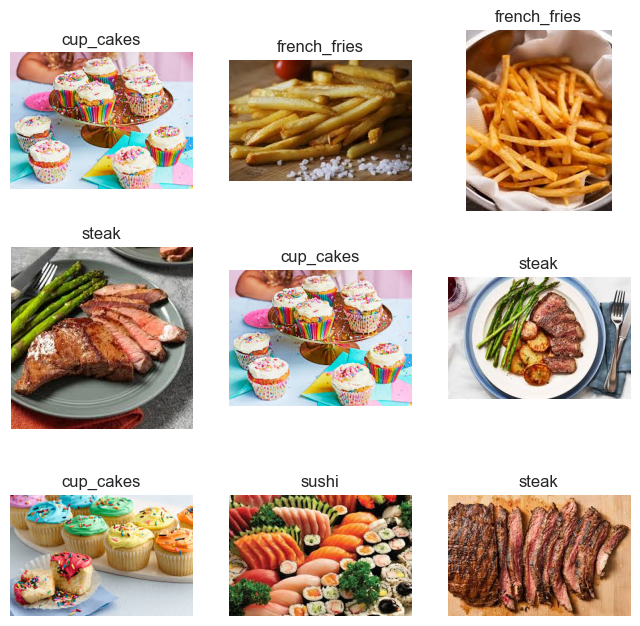

In [7]:
utilities.plot_samples(
    path=TEST_SET_FOLDER,
    classes_names=final_test_dataset.classes,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


NameError: name 'plt' is not defined

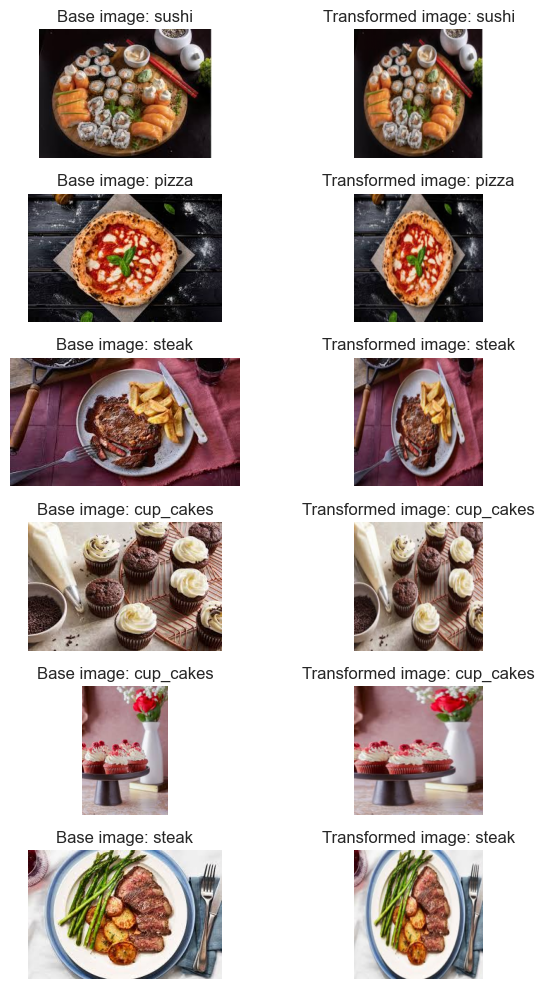

In [8]:
utilities.plot_samples_transformed(
    path=TEST_SET_FOLDER,
    classes_names=final_test_dataset.classes,
    transform=transform
)
plt.axis('off')

In [ ]:
final_test_dataset.class_to_idx

In [9]:
from torch.utils.data import DataLoader
final_test_dataloader = DataLoader(
    dataset=final_test_dataset,
    batch_size=32,
)

In [10]:
device = 'mps' if torch.mps.is_available() else 'cpu'
model0.to(device=device)
loss_list = []
acc_list = []
for X_batch, y_batch in final_test_dataloader:
    loss_batch, acc_batch = model0.eval_step(
        batch_test_X=X_batch,
        batch_test_y=y_batch,
        loss_foo=nn.CrossEntropyLoss(),
        device=device,
    )
    loss_list.append(loss_batch)
    acc_list.append(acc_batch)


In [11]:
from numpy import mean
mean_loss = mean(loss_list)
mean_acc = mean(acc_list)

print(f'Mean loss: {mean_loss:.3f} | Mean acc: {mean_acc:.3%}')

Mean loss: 0.909 | Mean acc: 67.841%


In [12]:
def predict(X_batch, model, device):
    pred_list = []
    model0.eval()
    with torch.no_grad():
        for X_batch, y_batch in final_test_dataloader:
            X_batch = X_batch.to(device)
            pred = model0(X_batch)
            pred_list.append(pred)
    return torch.vstack(pred_list)

logits = predict(X_batch, model0, device)
pred_proba = torch.softmax(logits, dim=1)
prediction = torch.argmax(pred_proba, dim=1)

Text(0.5, 1.0, 'Original label: 0 | Predicted label: 3')

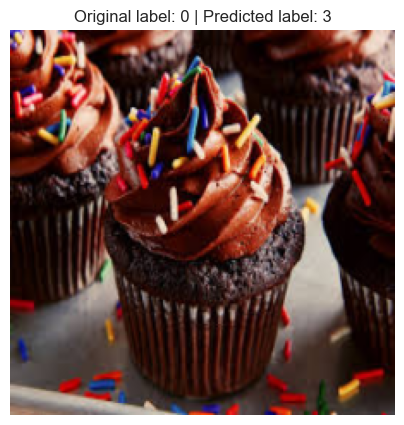

In [13]:
from random import randint
import matplotlib.pyplot as plt
random_pic = randint(0, len(final_test_dataset))
plt.figure(figsize=(5, 5))
plt.imshow(final_test_dataset[random_pic][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"Original label: {final_test_dataset[random_pic][1]} | Predicted label: {prediction[random_pic]}")


In [14]:
final_test_dataset.class_to_idx

{'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4}

In [15]:
targets = torch.Tensor(final_test_dataset.targets)

Text(0.5, 1.0, 'Confusion Matrix')

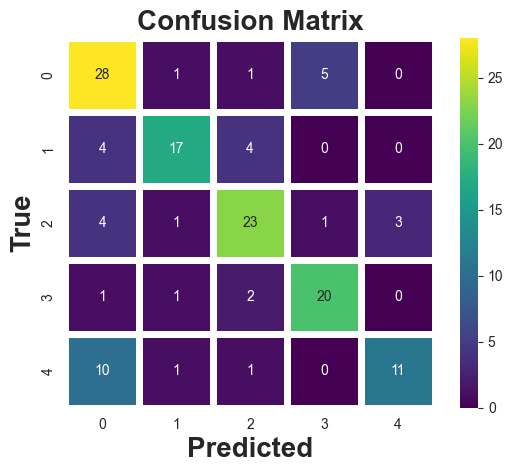

In [16]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction.to('cpu')),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')